# Efficient Coding in R

## Code Benchmarking and Profiling
Profiling your code can help you identify performance bottlenecks and optimize for better efficiency. R provides packages for profiling purposes:

- **Benchmark**: Use `microbenchmark`, `bench` or `system.time()` to compare different implementations.
- **Profile**: profvis can visualize time and memory(!) used


In [1]:
library(microbenchmark)

slow_function <- function() {
  y <- numeric(1000000)
  for (i in 1:1000000) y[i] <- i^2
  return(y)
}

faster_function <- function() {
  x <- 1:1000000
  y <- x^2
  return(y)
}


slow <- microbenchmark(slow_function(), unit = "ms")
fast <- microbenchmark(faster_function(), unit = "ms")
print(slow)
print(fast)

Unit: milliseconds
            expr     min      lq     mean   median       uq      max neval
 slow_function() 50.9932 62.6974 75.51366 70.18915 84.41715 151.7394   100
Unit: milliseconds
              expr    min       lq     mean   median       uq     max neval
 faster_function() 3.5447 3.625151 5.362255 3.770901 4.855452 44.5784   100


The slow function uses an explicit loop (for loop), which is inefficient.
The faster function uses vectorization (x^2), which is much more efficient.

In [2]:
df <- data.frame(iris[,1:4])
mat <- as.matrix(iris[,1:4])

df_access <- microbenchmark(df[,1], unit = "us")
mat_access <- microbenchmark(mat[,1], unit = "us")

print(df_access)
print(mat_access)

Unit: microseconds
    expr   min    lq    mean median    uq    max neval
 df[, 1] 6.401 8.201 8.57194  8.351 8.501 51.102   100
Unit: microseconds
     expr min    lq    mean median    uq  max neval
 mat[, 1] 0.9 0.901 1.70498  1.001 1.101 22.2   100


Data frames are more flexible (support mixed data types) but are slower than matrices for numerical operations.
Matrices are optimized for numerical operations and faster for subsetting.
If you are working with numeric-only data, converting a data.frame to a matrix can improve performance.

#### Profiling
Benchmarking tells us how long a function takes, but profiling shows us where the function spends its time.
Profiling your code with `profvis` generates an interactive visual representation of the execution time of different parts of your code, allowing you to identify areas for optimization.

HTML widgets cannot be represented in plain text (need html)

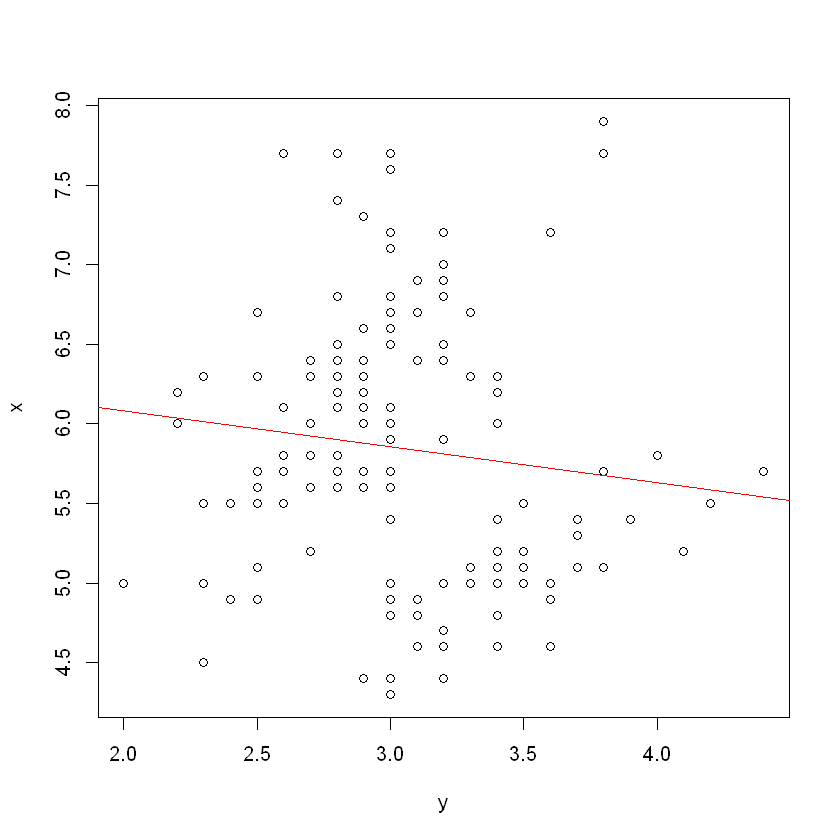

In [3]:
library(profvis)

# Profile the following code with the profvis function
profvis({
    dat <- data.frame(
        x = iris$Sepal.Length,
        y = iris$Sepal.Width
    )
    plot(x ~ y, data = dat)
    m <- lm(x ~ y, data = dat)
    abline(m, col = "red")
})

## Data Structure
When working with large data sets, choosing the right data structure can improve performance and memory efficiency. While base R provides useful data manipulation functions, `dplyr` and `data.table` offer optimized alternatives that are faster and more efficient, especially for large data sets.

In [4]:
library(dplyr)
library(data.table)
library(microbenchmark)

large_df <- data.frame(
  ID = 1:100000,
  Value = rnorm(100000),
  Category = sample(letters[1:5], 100000, replace = TRUE)
)


Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union



Attache Paket: 'data.table'


Die folgenden Objekte sind maskiert von 'package:dplyr':

    between, first, last




In [5]:
# Using base R
base_r_time <- microbenchmark(
  large_df[large_df$Category == "a", ], 
  unit = "ms"
)

# Using dplyr
dplyr_time <- microbenchmark(
  large_df %>% filter(Category == "a"), 
  unit = "ms"
)

# Using data.table
large_dt <- data.table(large_df)
data_table_time <- microbenchmark(
  large_dt[Category == "a"], 
  unit = "ms"
)

print(base_r_time)
print(dplyr_time)
print(data_table_time)

Unit: milliseconds
                                 expr      min     lq    mean   median       uq
 large_df[large_df$Category == "a", ] 3.493102 3.7804 4.40083 3.936101 4.397251
     max neval
 11.5714   100
Unit: milliseconds
                                 expr      min       lq     mean   median
 large_df %>% filter(Category == "a") 2.419901 3.051901 3.696565 3.183201
       uq     max neval
 3.767752 12.8902   100
Unit: milliseconds
                      expr      min      lq     mean   median       uq    max
 large_dt[Category == "a"] 2.569201 2.76415 3.355367 2.882751 3.219601 23.562
 neval
   100


**Base R**: Can be efficient for small datasets, but lacks optimizations for large datasets. Each operation creates a copy of the dataset, leading to memory inefficiency.

**dplyr**: This is part of the tidyverse and uses efficient backends for performance gains. The pipe operator (`%>%`) allows chaining operations in a readable way. It provides a consistent set of verbs to help solve the most common data manipulation challenges (e.g. `mutate()`, `select()`, `summarise()`).

**data.table**: Provides an enhanced version of `data.frame` and is designed for big data processing in R. It uses in-place modifications to avoid memory overhead.

## Vectorization

Vectorization is a key technique to improve performance in R. Instead of using loops, use vectorized operations whenever possible.
Vectorizing refers to applying a function to a whole vector or array of data at once, rather than iterating through the elements one by one. R is designed to work with vectorized operations, which are inherently faster and more efficient than loops for many tasks (especially for larger datasets).

In [6]:
## Pre-allocation ##
# Memory is pre-allocated, preventing expensive resizing. 
# But looping is still inefficient since R has to access and modify each element one-by-one.

pre_allocate <- function(n){
    x <- vector("numeric", n) # Memory is pre-allocated
    for (i in 1:n)
        x[i] <- i
}

pre_allocate_time <- microbenchmark(pre_allocate(1000), unit = "ms")
print(pre_allocate_time)

Unit: milliseconds
               expr    min       lq       mean   median       uq      max neval
 pre_allocate(1000) 0.0425 0.042801 0.08549906 0.042901 0.043351 2.808101   100


In [7]:
## vectorized ##
# R internally allocates memory all at once, avoiding costly resizing

vectorized <- function(n){
    x <- 1:n # directly creates the entire vector in one step
}
vectorized_time <- microbenchmark(vectorized(1000), unit = "ms")
print(vectorized_time)

Unit: milliseconds
             expr   min       lq       mean   median    uq      max neval
 vectorized(1000) 3e-04 0.000301 0.01416502 0.000301 4e-04 1.371502   100


In [8]:
## The worst !! ##
# At each iteration, more memory is requested, which can take hours to run if large vectors are created
# Every step, R creates a completely new vector. The old vector is copied into new memory, making this slower and slower as n increases.
# This can take hours if n is large!

growing_vector <- function(n){
    x <- NULL
    for (i in 1:n)
        x <- c(x,i) # Creates new vector at each step
}

growing_vector_time <- microbenchmark(growing_vector(1000), unit = "ms")
print(growing_vector_time)

Unit: milliseconds
                 expr   min       lq    mean  median       uq     max neval
 growing_vector(1000) 1.469 1.967951 2.50677 2.11085 2.364251 14.4803   100


#### Different Approaches
Different approaches for computing the mean of elements in a large list to demonstrate performance improvements through vectorization and alternative techniques.

In [9]:
## Setup ##

library(ggplot2)
library(microbenchmark)

# l <- list(-200000:-3, 4:800, c(3,1,660,28,9000), 1:20000, 50:100000, -700000:1, c(1,2))
# l <- list(1:5, c(3,1,66,2,90),-5:-1)
l <- lapply(1:100000, function(x) rnorm(sample(1:100, 1))) # list with 100000 elements, where each element is a numeric vector of random length (between 1 and 100)

Warning message:
"Paket 'ggplot2' wurde unter R Version 4.4.2 erstellt"


**Loop**: Iterate through the list using a for loop, manually computing the mean for each element. 
Loops in R are inefficient because R is an interpreted language, not compiled.
Each iteration accesses list elements individually, creating a lot of overhead.

In [10]:
## Loop ##
loop_means <- function(l) {
  result <- numeric(length(l))
  for (i in 1:length(l)) {
    result[i] <- mean(l[[i]])
  }
  return(result)
}

loop_time <- microbenchmark(loop_means(l), times = 100, unit = "us")
print(loop_time)
print(mean(loop_time$time))

Unit: microseconds
          expr      min       lq     mean   median       uq      max neval
 loop_means(l) 629763.4 634631.9 646989.2 638464.2 647756.1 738257.2   100
[1] 646989248


**sapply**: vectorized function that applies the mean function to each element of the list automatically. It's more concise and typically faster than the loop approach. It applies a function to a list or vector and simplifies the result to a vector or matrix.

In [11]:
## sapply ##

sapply_means <- function(l) {
  sapply(l, mean)
}

sapply_time <- microbenchmark(sapply_means(l), times = 100, unit = "us")
print(sapply_time)
print(mean(sapply_time$time))

Unit: microseconds
            expr      min       lq     mean   median       uq     max neval
 sapply_means(l) 647827.7 744792.9 798297.8 785527.8 850646.3 1072669   100
[1] 798297836


**Vectorize**: creates a function wrapper that vectorizes the action of its argument FUN. It operates element-wise on a list.

In [12]:
## Vectorize ##
vectorized_mean <- Vectorize(mean)
vectorized_means <- function(l) {
  vectorized_mean(l)
}

vectorize_time <- microbenchmark(vectorized_means(l), times = 100, unit = "us")
print(vectorize_time)
print(mean(vectorize_time$time))

Unit: microseconds
                expr      min       lq     mean   median       uq     max neval
 vectorized_means(l) 663733.3 756550.4 807831.7 791060.7 836495.1 1159963   100
[1] 807831673


**unlist**: combines lapply() (which applies mean efficiently) with unlist(), which flattens the result into a vector.

In [13]:
## Unlist ##
unlist_means <- function(l) {
  unlist(lapply(l, mean))
}

unlist_time <- microbenchmark(unlist_means(l), times = 100, unit = "us")
print(unlist_time)
print(mean(unlist_time$time))

Unit: microseconds
            expr      min       lq     mean   median       uq     max neval
 unlist_means(l) 652861.7 762789.3 951087.8 821284.2 951956.9 2181870   100
[1] 951087768


In [14]:
times <- rbind(
  data.frame(Method = "loop", Time = loop_time$time),
  data.frame(Method = "sapply", Time = sapply_time$time),
  data.frame(Method = "Vectorize", Time = vectorize_time$time),
  data.frame(Method = "unlist", Time = unlist_time$time)
)

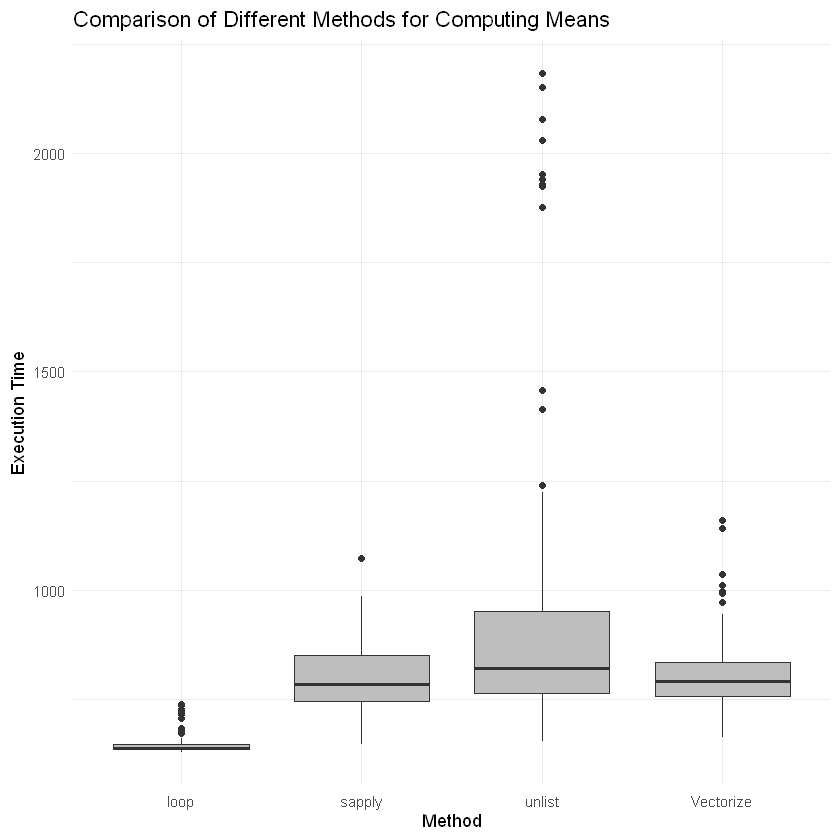

In [15]:
ggplot(times, aes(x = Method, y = Time/1e6)) +
  geom_boxplot(fill = "grey") +
  scale_y_continuous() + 
  theme_minimal() +
  labs(y = "Execution Time", title = "Comparison of Different Methods for Computing Means") +
  theme(legend.position = "none") 

**Rcpp**: The function is rewritten in C++ using Rcpp, allowing it to run significantly faster by avoiding R's interpretation overhead. Orders of magnitude faster than loops or sapply() since it uses compiled C++ code.

In [17]:
library(Rcpp)
library(microbenchmark)

# Define the Rcpp function
Rcpp::cppFunction(
    "
    NumericVector rcpp_mean(List l) {
        int n = l.size();
        NumericVector means(n);
        for (int i = 0; i < n; i++) {
            NumericVector v = l[i];
            means[i] = mean(v);
        }
        return means;
    }
    "
)

rcpp_time <- microbenchmark(rcpp_mean(l), times = 1000, unit = "us")
print(rcpp_time)
print(mean(rcpp_time$time))


times <- rbind(
  times,
  data.frame(Method = "Rcpp", Time = rcpp_time$time)
)


ggplot(times, aes(x = Method, y = Time, fill = Method)) +
  geom_boxplot() +
  scale_y_continuous() + 
  theme_minimal() +
  labs(y = "Execution Time (ms)", title = "Comparison of Different Methods for Computing Means") +
  theme(legend.position = "none") 


Fehler in system(paste(MAKE, p1(paste("-f", shQuote(makefiles))), "compilers"),  : 
  'make' not found
Ruft auf: <Anonymous> -> .shlib_internal -> system
Ausführung angehalten


ERROR: Error in sourceCpp(code = code, env = env, rebuild = rebuild, cacheDir = cacheDir, : Error 1 occurred building shared library.




Please download and install the appropriate version of Rtools:

http://cran.r-project.org/bin/windows/Rtools/




## Identification of Bottlenecks

- Given a matrix `mat` with **100 observations (rows)** and **10 batches (columns)**.
- The goal is to remove the batch effect using linear regression.

In [18]:
## Setup ##

# Matrix with random values
mat <- matrix(rnorm(100 * 10, mean = 10, sd = 3), nrow = 100, ncol = 10)

# Batch variable (e.g., batch effect groups)
batch <- factor(rep(1:10, each = 10))  # 10 batches, each with 10 observations

In [19]:
mat <- t(mat)

# Pre-allocate results?
corrected <- matrix(0, nrow = nrow(mat), ncol = ncol(mat))
for (i in 1:nrow(mat)) {
  corrected[i,] <- lm(mat[i,] ~ batch)$residuals
}

# Extend e.g. list on the fly?
corrected <- list()
for (i in 1:nrow(mat)) {
  corrected[[i]] <- lm(mat[i,] ~ batch)$residuals
}
corrected = do.call(rbind, corrected)

When there is something else slowing your code:

In [20]:
library(RcppArmadillo)
corrected = matrix(0, nrow = nrow(mat), ncol = ncol(mat))
for (i in 1:nrow(mat)) {
  corrected[i,] <- RcppArmadillo::fastLm(mat[i,], batch)$residuals
}

## Memory Optimization

- Integers use less memory than doubles -> integer(), `1L` instead of numeric(), `1`
- Characters are big, save memory by using factors -> Factors are actually integers, each name only stored once
- Convert big matrices to Matrix::sparseMatrix() -> sparse_mat = as(mat, "sparseMatrix")
- Sometimes, the containing env is attached to an object. Check object size with pryr::object_size()

## Garbage Collection

- If a lot of memory is blocked after a big operation, use R’s garbage collection gc()
- If gc() doesn’t free (enough) memory, try mallinfo::malloc.trim() (https://github.com/Laurae2/mallinfo)

## Parallelization

By default, R runs operations single-threaded, meaning it uses only one CPU core.
When dealing with large datasets or intensive computations, using multiple CPU cores can significantly speed up execution.
The `parallel` package allows to distribute computations across multiple cores.

In [21]:
large_matrix <- matrix(rnorm(1e6), nrow = 10000, ncol = 100)

In [22]:
library(microbenchmark)
library(parallel)

# Single-threaded apply
apply_time <- microbenchmark(apply(large_matrix, 2, mean), times = 10)

# Multi-threaded parApply
n_cores <- detectCores() # determine number of cores in your machine
cl <- makeCluster(n_cores)  # create cluster
parapply_time <- microbenchmark(parApply(cl, large_matrix, 2, mean), times = 10)
stopCluster(cl) # stop cluster 

print(apply_time)
print(parapply_time)

Unit: milliseconds
                         expr    min     lq     mean   median      uq     max
 apply(large_matrix, 2, mean) 13.036 18.519 22.27654 23.09195 26.6698 27.9892
 neval
    10
Unit: milliseconds
                                expr     min      lq     mean   median      uq
 parApply(cl, large_matrix, 2, mean) 43.8251 59.0374 82.30911 65.64165 76.4722
      max neval
 225.1728    10


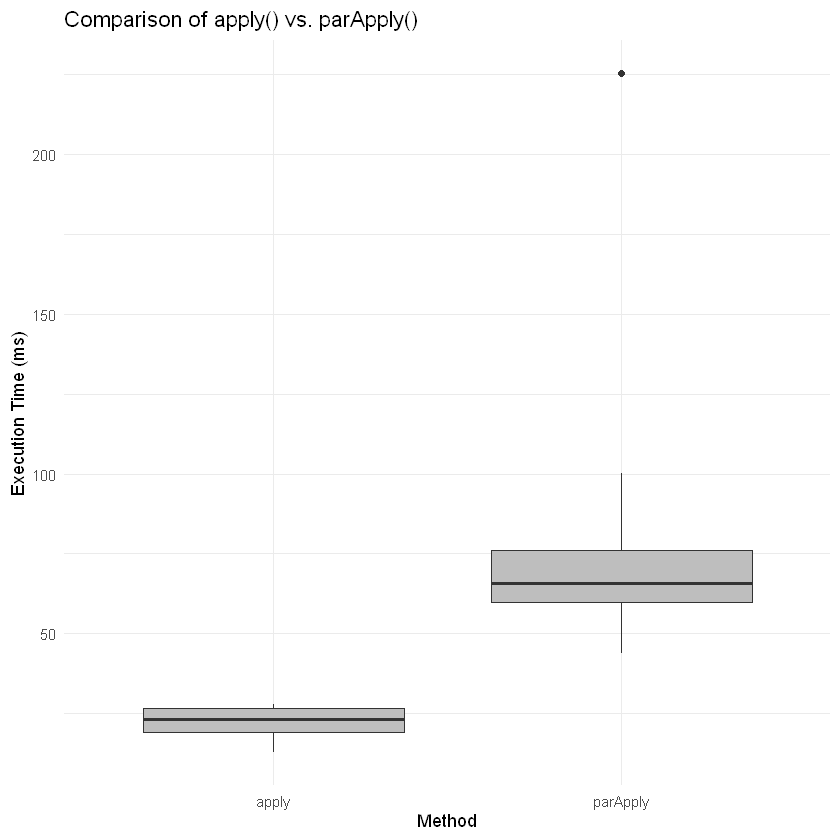

In [23]:
library(ggplot2)

times <- data.frame(
  Method = rep(c("apply", "parApply"), each = 10),
  Time = c(apply_time$time, parapply_time$time) / 1e6  # Convert to milliseconds
)

ggplot(times, aes(x = Method, y = Time)) +
  geom_boxplot(fill = "grey") +
  theme_minimal() +
  labs(y = "Execution Time (ms)", title = "Comparison of apply() vs. parApply()") +
  theme(legend.position = "none")

In [24]:
# Runs single-threaded (uses only one CPU core
means = apply(iris[,1:4], 2, mean)
print(means)

Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
    5.843333     3.057333     3.758000     1.199333 


In [25]:
# Runs operations in parallel using multiple CPU cores

library("parallel")

n_cores <- detectCores() # determine number of cores in your machine

cl = makeCluster(n_cores) # create cluster
means = parApply(cl, iris[,1:4], 2, mean) 
stopCluster(cl) # stop cluster

print(means)

Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
    5.843333     3.057333     3.758000     1.199333 


## Linear Index <-> 2D Index

In [26]:
mat[3]
mat[3,1]

r = ((ind-1) %% nrow(mat)) + 1
c = floor((ind-1) / nrow(mat)) + 1

ind = (c-1)*nrow(mat) + r

[1] 7.615751

[1] 7.615751

ERROR: Error: Objekt 'ind' nicht gefunden
